## Spark ML


## K-means with Spark

### But first, sklearn

In [ ]:
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
import pandas as pd
import numpy as np


Feature matrix for sklearn 



 [[177.8       68.04    ]
 [182.88      73.03    ]
 [187.96      74.84    ]
 ...
 [185.42      79.832192]
 [187.96      87.996848]
 [182.88      78.925008]]




Cluster Centers 
 [[183.11055976  78.04311321]
 [204.01642857 103.91643194]] 
 from sklearn kmeans


========Plot the two clusters===========


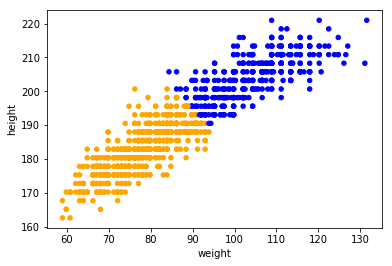

In [ ]:
df = pd.read_csv('nbasoccer.csv')
players = df[['player_height','player_weight']]
X = players.to_numpy()
print(f'Feature matrix for sklearn \n\n\n\n {X}\n\n\n\n')

#Initialize KMeans object
kmeans = KMeans(n_clusters=2, random_state=0) 

#Fit the data
kmeans.fit(X)

print(f'Cluster Centers \n {kmeans.cluster_centers_} \n from sklearn kmeans\n\n')

print('========Plot the two clusters===========')
players['label'] = kmeans.labels_
players.columns = ['height','weight','label']
color_dict = {0:'orange',
             1:'blue'}
players['color'] = players['label'].apply(lambda x:color_dict[x])
players.plot.scatter(x='weight',y='height',c=players['color'])

### Spark ML Library Kmeans

---Script Starts

In [ ]:
from pyspark.sql import SparkSession # Spark Session Class for create a Spark Session
from pyspark.ml.clustering import KMeans
# create a spark session object
# following some builder pattern

spark = SparkSession.builder \
                    .master("local") \
                    .appName("kmeans") \
                    .getOrCreate() 

dfReader = spark.read # Spark interface to read external reader

dataset = dfReader.option("header", "true") \
           .option("inferSchema", value = True) \
           .csv("nbasoccer.csv")


"""
+--------------+
| features     |
+--------------+
|[177.8,68.04] |
|[182.88,73.03]|
|[187.96,74.84]|
|[180.34,75.3] |
+--------------+
"""
dataset.show()


+----------------+----+-------------+-------------+------+
|     player_name|team|player_height|player_weight|league|
+----------------+----+-------------+-------------+------+
|      Tyler Ulis| PHX|        177.8|        68.04|   NBA|
|    Aaron Brooks| IND|       182.88|        73.03|   NBA|
|   Briante Weber| CHA|       187.96|        74.84|   NBA|
|  John Lucas III| MIN|       180.34|         75.3|   NBA|
|     Tim Frazier| NOP|       185.42|        77.11|   NBA|
|Brandon Jennings| WAS|       185.42|        77.11|   NBA|
|   Isaiah Taylor| HOU|        190.5|        77.11|   NBA|
| Dejounte Murray| SAS|       195.58|        77.11|   NBA|
| Dennis Schroder| ATL|       185.42|        78.02|   NBA|
|   Brian Roberts| CHA|       185.42|        78.47|   NBA|
|    Lou Williams| HOU|       185.42|        79.38|   NBA|
|     Mike Conley| MEM|       185.42|        79.38|   NBA|
|  Shabazz Napier| POR|       185.42|        79.38|   NBA|
|     Norris Cole| OKC|       187.96|        79.38|   NB

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["player_height", "player_weight"],
    outputCol="features")

df = assembler.transform(dataset)
df.select("features").show(truncate=False)


+--------------+
|features      |
+--------------+
|[177.8,68.04] |
|[182.88,73.03]|
|[187.96,74.84]|
|[180.34,75.3] |
|[185.42,77.11]|
|[185.42,77.11]|
|[190.5,77.11] |
|[195.58,77.11]|
|[185.42,78.02]|
|[185.42,78.47]|
|[185.42,79.38]|
|[185.42,79.38]|
|[185.42,79.38]|
|[187.96,79.38]|
|[187.96,79.38]|
|[182.88,79.38]|
|[182.88,79.38]|
|[198.12,79.38]|
|[187.96,79.38]|
|[182.88,79.38]|
+--------------+
only showing top 20 rows



In [ ]:
df.show()

+----------------+----+-------------+-------------+------+--------------+
|     player_name|team|player_height|player_weight|league|      features|
+----------------+----+-------------+-------------+------+--------------+
|      Tyler Ulis| PHX|        177.8|        68.04|   NBA| [177.8,68.04]|
|    Aaron Brooks| IND|       182.88|        73.03|   NBA|[182.88,73.03]|
|   Briante Weber| CHA|       187.96|        74.84|   NBA|[187.96,74.84]|
|  John Lucas III| MIN|       180.34|         75.3|   NBA| [180.34,75.3]|
|     Tim Frazier| NOP|       185.42|        77.11|   NBA|[185.42,77.11]|
|Brandon Jennings| WAS|       185.42|        77.11|   NBA|[185.42,77.11]|
|   Isaiah Taylor| HOU|        190.5|        77.11|   NBA| [190.5,77.11]|
| Dejounte Murray| SAS|       195.58|        77.11|   NBA|[195.58,77.11]|
| Dennis Schroder| ATL|       185.42|        78.02|   NBA|[185.42,78.02]|
|   Brian Roberts| CHA|       185.42|        78.47|   NBA|[185.42,78.47]|
|    Lou Williams| HOU|       185.42| 

In [ ]:
#initialize Spark Kmeans
kmeans = KMeans(k=2, seed=1)
#Fit
model = kmeans.fit(df.select("features")) #or kmeans.fit(df) also works. by default "features" col will be used to fit the model
# Get Center
centers = model.clusterCenters()
print(f'Centers from Spark ML Kmeans \n {centers}\n')

Centers from Spark ML Kmeans 
 [array([183.11055976,  78.04311321]), array([204.01642857, 103.91643194])]



---Script Ends

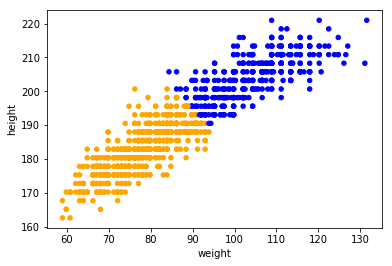

In [ ]:
#apply transform to get labels
labels = model.transform(df)

players=labels.select('player_height','player_weight','prediction').toPandas()

players.columns = ['height','weight','label']
color_dict = {0:'orange',
             1:'blue'}
players['color'] = players['label'].apply(lambda x:color_dict[x])
players.plot.scatter(x='weight',y='height',c=players['color'])

In [ ]:
spark.stop()